In [77]:
import random

import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
import geopandas as gpd
import folium

from nsvd import NSVD, plot_img

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [78]:
tf = transforms.Compose([
  transforms.RandomResizedCrop((224, 224), (0.7, 1)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])
tf1 = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

norm_tf = transforms.Compose([
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Used for custom image
#img = Image.open('./data/test_images/my_image.png').convert('RGB')
#img = tf(img)

test = NSVD('./data', False, 'county', True, transforms=tf)
test1 = NSVD('./data', False, 'county', False, transforms=tf1)

tensor(4., device='cuda:0') [62.61026382 11.846383  ]


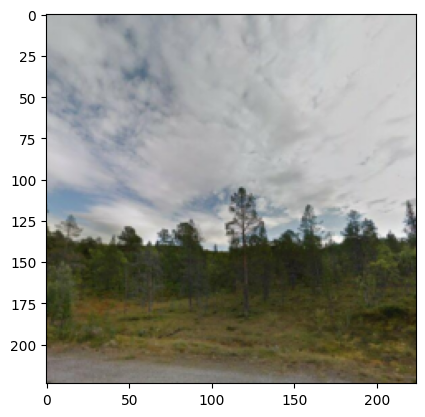

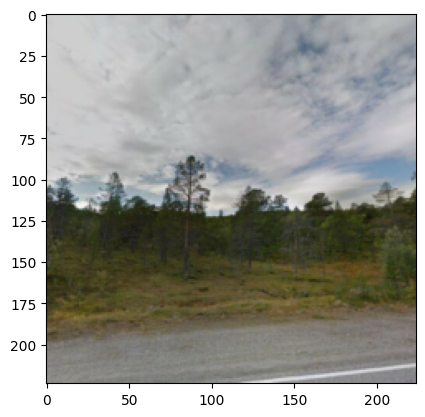

In [79]:
# comment these out if using custom image
idx = random.randint(0, len(test)-1)
img, county, coords = test[idx]
img1, county1, _ = test[idx]

img, county = img.to(device), torch.tensor(county).to(device).float()
print(county, coords)

plot_img(img.cpu())
plot_img(img1)
img = norm_tf(img)


In [ ]:
model = torch.load('./data/trained_models/county/my_model')
model.to(device)
model.eval()

with torch.no_grad():
  y = model(img.unsqueeze(0)).flatten()
  guessed_county = torch.argmax(torch.exp(y)).item()


In [80]:
df = pd.read_json("./data/norge.geojson")
fylker = df["administrative_enheter.fylke"]["features"]

In [88]:
import folium

FYLKESNUMMER_INDEX = [42, 3, 54, 15, 38, 50, 11, 34, 30, 18, 46]

fylke = None
for f in fylker:
    if int(f["properties"]["fylkesnummer"]) == FYLKESNUMMER_INDEX[guessed_county]:
        fylke = f
        break


In [89]:
gdf = gpd.GeoDataFrame.from_features([fylke], crs=25833)

In [90]:

gdf = gdf.to_crs(epsg=4326)
geo_j = folium.GeoJson(data=gdf["geometry"][0])

m = folium.Map((64.9701, 13.509217), zoom_start=4)
geo_j.add_to(m)
folium.CircleMarker(location=(coords[0], coords[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)

m